In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.datasets import load_boston, load_iris, load_breast_cancer

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

from IPython.core.display import display, HTML

In [2]:
from Utils import prepareData, plot2Dimensions, plot_Kneighbors, my_final_plot_comparison, plot_decision_boundary_k

# **Loading**

In [3]:
#Data Frame para classificação
iris_df, description_clas = prepareData(load_iris)
cancer_df, description_clas = prepareData(load_breast_cancer)
#Select your data-set
df = iris_df
#Data Frame para regressão
df_regr, description_regr = prepareData(load_boston)

# **Cronograma e Requisitos**

Cronograma:

- Classificação:
  1. Entender a intuição do algoritmo - 2D.
  2. Implementar o algoritmo de **KNN** para classificação.
  3. Utilizar o algoritmo **KNeighborsClassifier** do Sklearn para nos apronfundar no algoritmo.
- Regressão:
    4. Exemplificar KNN para regressão - ND.
-Extra:
    5. Aplicações.
    6. Retomar alguns pontos importantes.

Requisitos:

1. Dominar python e pandas.
2. Entender o *trade off* bias-variance (viés-variância).
3. Train Split Test.

# **K-nearest neighbors**

## **Intuição do algoritmo** 

Pontos principais:

- Usado para problemas de **classificação** e **regressão**.

- Cada exemplo é representado por um vetor no $\mathbb{R}^n$ e seu label.

- O algoritmo pode ser resumido em dois passos:
  - Calcula a **distância** do *exemplo test* para todos os exemplos do dataset.
  
  - Seleciona os $K$ vizinhos mais próximos e calcula o resultado.

- **Não** possui uma fase explícita de treinamento (lazy).

Vamos classificar tipos de planta com base no tamanho da pétala e da sépala.

In [4]:
features = df.columns.tolist()[:-1]
print(f"Temos {len(features)} features: {features}\n")

Temos 4 features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']



Visando simplificar o entendimento vamos começar em duas dimensões, usando as features da pétala.

In [5]:
X_Features = df.filter(regex = "feature")
X_2D = X_Features.iloc[:,:2]
y = df.filter(regex = "target")

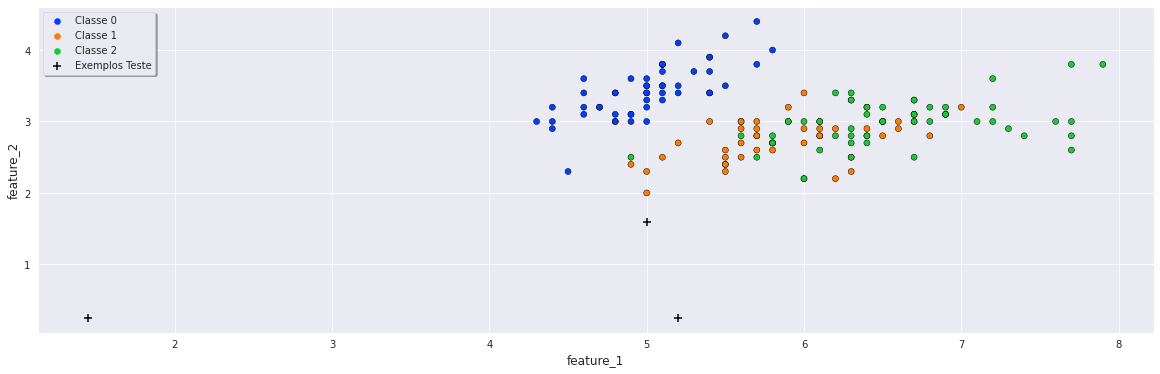

In [6]:
# Vamos brincar com 2 dimensões.
fst_dim = X_2D.iloc[:,0].name
snd_dim = X_2D.iloc[:,1].name

test_examples = np.array([[1.45, 0.25],
                          [5.2,0.25],
                          [5,    1.6],])

plot2Dimensions(df, fst_dim, snd_dim, test_examples)

## **Implementação do algoritmo**

- Utiliza a métrica de distância de Minkowski:

$$D(X,Y) = (\sum_{i=1}^{n} |x_i - y_i|^p)^{\frac{1}{p}}$$
  
- Normalmente é importante realizar **Normalização** dos dados!!!

In [7]:
examples_distance_data = euclidean_distances(X_2D, test_examples)
columns = [f"distance-{col+1}" for col in range(examples_distance_data.shape[1])]
examples_distance_df = pd.DataFrame(data=examples_distance_data, columns=columns)

In [8]:
df_distance_class = pd.concat([X_2D, y, examples_distance_df], axis = 1)

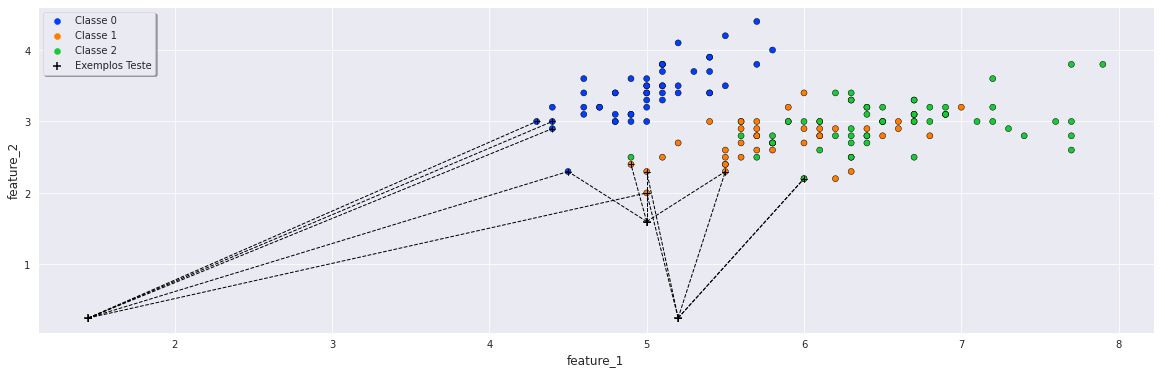

In [9]:
plot_Kneighbors(df_distance_class, fst_dim, snd_dim, test_examples, figsize=((20,6)), k_neighbors=5)

In [10]:
k = 5
example_test = "distance-1"
df_distance_class.nsmallest(k, example_test).filter(regex=f"feature|target")

,feature_1,feature_2,target
41,4.5,2.3,0.0
60,5.0,2.0,1.0
13,4.3,3.0,0.0
8,4.4,2.9,0.0
38,4.4,3.0,0.0


In [11]:
"""
 - value_counts(normalize=True) : Realiza o voto majoritario:

 - idxmax() : Seleciona a classe com maior voto.
"""

for col in df_distance_class.filter(regex = "distance"):
    print(f"Checando exemplo teste: {col.split('-')[1]}")
    examplo_classe = df_distance_class.nsmallest(k, col)["target"].value_counts(normalize=True).idxmax()
    print(examplo_classe)

Checando exemplo teste: 1
0.0
Checando exemplo teste: 2
1.0
Checando exemplo teste: 3
1.0


- Não funciona bem para dataset grandes.

## **Sklearn - KNeighborsClassifier**

In [12]:
#Separando os dados ... 
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, test_size=0.1, random_state=42)

In [13]:
knn = KNeighborsClassifier(n_neighbors = 5,
                           weights     = "uniform", 
                           algorithm   = "auto",      #Algoritmo usado para encontrar os vizinhos mais próximos
                           n_jobs      = 1,           #Número de processos para encontrar os vizinhos mais próximos
                           metric      = "minkowski", #Métrica de distância
                           p           = 2,           #Distância Euclidiana
                          )

### **Procedimento Usual** 

In [14]:
def my_pipeline(X_train, X_test, y_train, y_test, model):

    model.fit(X_train, y_train.target.values)
    
    #Prevendo o valor dos exemplos
    y_hat = pd.Series(model.predict(X_test), name="target")
    
    #Vamos montar datasets para plotar os dados
    test_df = pd.concat([X_test.reset_index(drop=True), y_hat], axis=1)
    train_df = pd.concat([X_train, y_train], axis=1)
    
    return test_df, train_df

knnSklearn_df, train_df = my_pipeline(X_train, X_test, y_train, y_test, knn)

In [15]:
final_data = pd.concat([train_df.assign(tipo="Treino"),knnSklearn_df.assign(tipo="Test")])

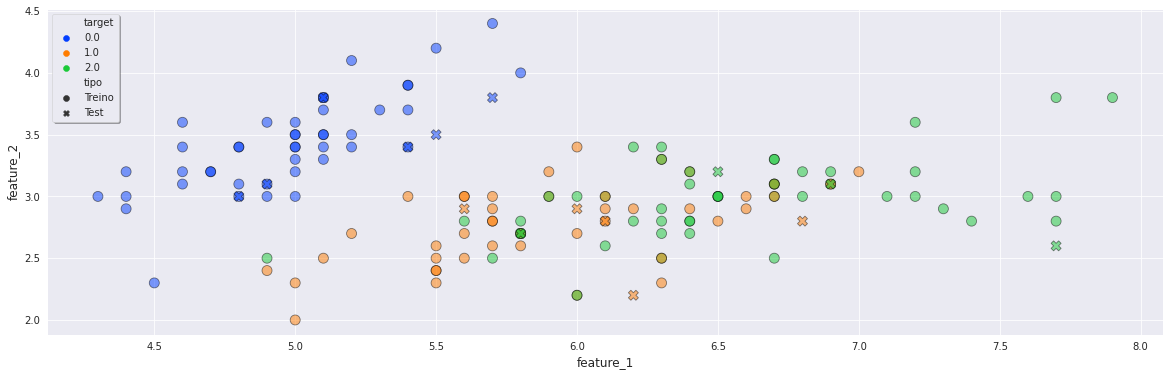

In [16]:
my_final_plot_comparison(final_data, fst_dim, snd_dim)

### **E se $K$ for igual ao número de exemplos no Treino?** 

In [17]:
knn = KNeighborsClassifier(n_neighbors = X_train.shape[0],
                           weights   = "uniform", 
                           algorithm = "auto",      #Algoritmo usado para encontrar os vizinhos mais próximos
                           n_jobs    = 1,           #Número de processos para encontrar os vizinhos mais próximos
                           metric    = "minkowski", #Métrica de distância
                           p         = 2,           #Distância Euclidiana
                          )

In [18]:
knnSklearn_df, train_df = my_pipeline(X_train, X_test, y_train, y_test, knn)
final_data = pd.concat([train_df.assign(tipo="Treino"),knnSklearn_df.assign(tipo="Test")])

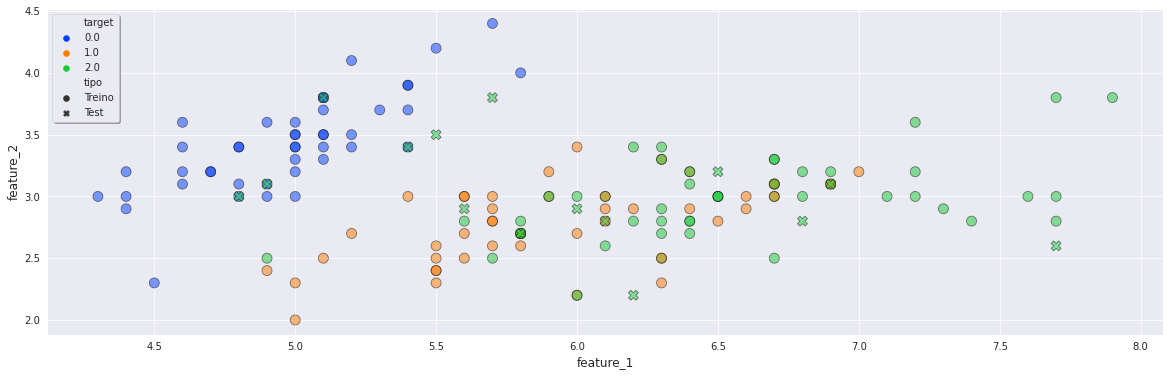

In [19]:
my_final_plot_comparison(final_data, fst_dim, snd_dim)

In [20]:
#Estou fazendo o voto majoritario referente ao dataset de treino
y_train["target"].value_counts(normalize=True).idxmax()

2.0

Resumindo, dane-se a posição do ponto, eu voto no que eu mais vejo!

### **Como selecionar o K correto ?** 

Ajustei uma função de plot de fronteira de decisão baseado no seguinte site:

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

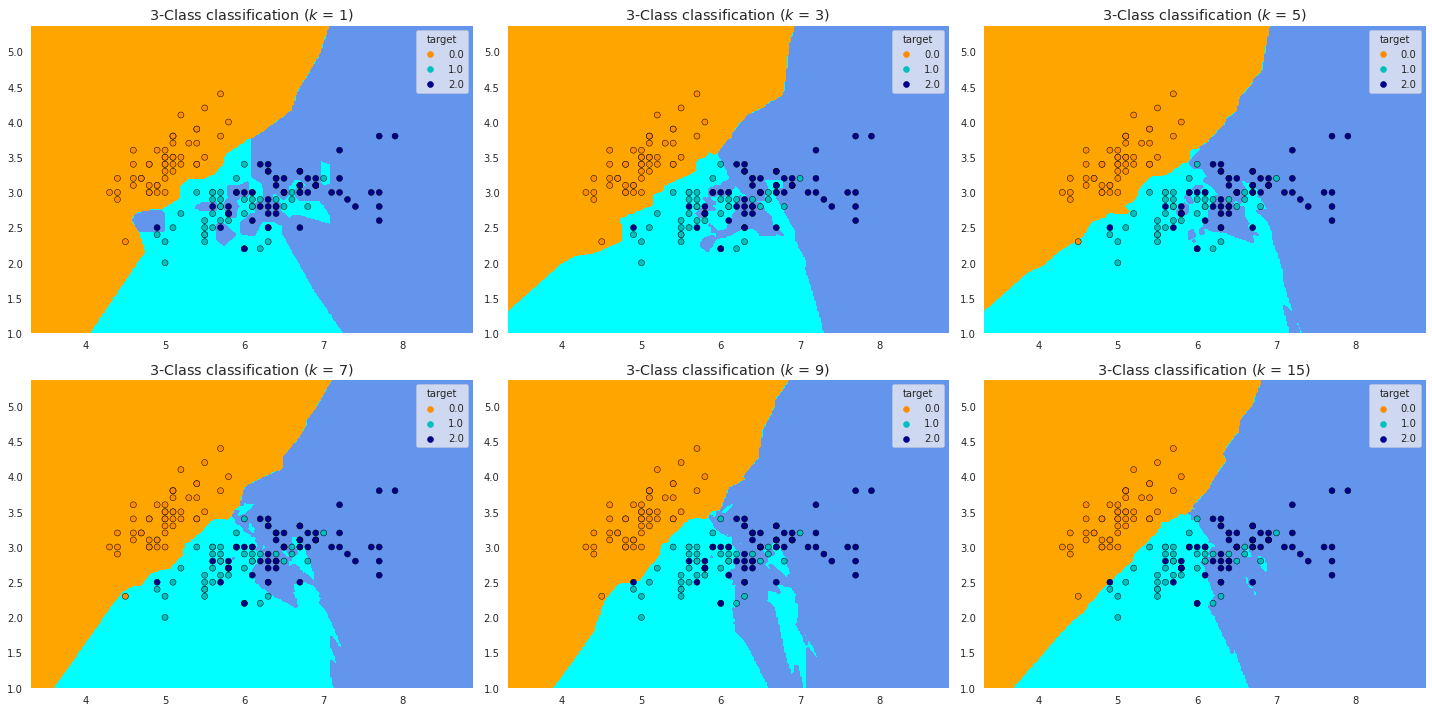

In [21]:
#Selecionar um número de valor k multiplos de 3, caso contrario alguns valores de k não serão utilizados.
n_neighbors_lst = [1,3,5,7,9,15]
    
plot_decision_boundary_k(X_2D, y, n_neighbors_lst)

- Maior: $K \rightarrow $ underfitting
- Menor: $K \rightarrow $ overfitting.

## **Regressão**

In [22]:
knn = KNeighborsRegressor()

## **Aplicações**